In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.sparse as sp
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

2025-09-01 09:38:55.990424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756719536.186080      78 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756719536.243280      78 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = "/kaggle/input/movie-lens-small-latest-dataset" 
print(os.listdir(data_path))

['movies.csv', 'ratings.csv', 'README.txt', 'tags.csv', 'links.csv']


In [3]:
movies = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/movies.csv")
df = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/ratings.csv")

In [4]:
# Data preprocessing
# Reindex users and movies to have consecutive indices
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

df['user_idx'] = df['userId'].map(user_to_idx)
df['movie_idx'] = df['movieId'].map(movie_to_idx)

num_users = len(user_ids)
num_movies = len(movie_ids)
num_ratings = len(df)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
def create_bipartite_graph(ratings_df, num_users, num_movies):
    """
    Create a bipartite graph from ratings
    """
    # Create adjacency lists for each type of rating
    rating_types = sorted(ratings_df['rating'].unique())
    
    # Dictionary to store edges by rating type
    edges_by_rating = defaultdict(list)
    
    for _, row in ratings_df.iterrows():
        user_idx = int(row['user_idx'])  # Ensure type int
        movie_idx = int(row['movie_idx'])  # Ensure type int
        rating = row['rating']
        
        # Add edge user -> movie
        edges_by_rating[rating].append([user_idx, movie_idx + num_users])
        # Add edge movie -> user (undirected graph)
        edges_by_rating[rating].append([movie_idx + num_users, user_idx])
    
    return edges_by_rating, rating_types

# Create the graph for training
train_edges, rating_types = create_bipartite_graph(train_df, num_users, num_movies)

In [6]:
class GCMCLayer(layers.Layer):
    """
    Graph Convolutional Layer for GCMC
    """
    def __init__(self, output_dim, num_relations, activation='relu', **kwargs):
        super(GCMCLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.num_relations = num_relations
        self.activation = keras.activations.get(activation)
        
    def build(self, input_shape):
        # Weights for each relation type
        self.relation_weights = []
        for r in range(self.num_relations):
            w = self.add_weight(
                shape=(input_shape[0][-1], self.output_dim),  # input_shape[0] for node_features
                initializer='glorot_uniform',
                name=f'relation_weight_{r}'
            )
            self.relation_weights.append(w)
            
        # Bias
        self.bias_weight = self.add_weight(
            shape=(self.output_dim,),
            initializer='zeros',
            name='bias_weight'
        )
        
        super(GCMCLayer, self).build(input_shape)
        
    def call(self, inputs):
        # inputs: [node_features, adjacency_matrices]
        node_features, adj_matrices = inputs
        
        outputs = []
        
        # For each relation type
        for r in range(self.num_relations):
            # Multiply by adjacency matrix
            adj_r = adj_matrices[r]
            
            # Convolution: A * X * W
            support = tf.matmul(node_features, self.relation_weights[r])
            output = tf.sparse.sparse_dense_matmul(adj_r, support)
            outputs.append(output)
        
        # Sum contributions from all relations
        if outputs:
            output = tf.add_n(outputs)
            output = tf.nn.bias_add(output, self.bias_weight)
        else:
            # If no relations, return features with linear transformation
            output = tf.matmul(node_features, self.relation_weights[0])
            output = tf.nn.bias_add(output, self.bias_weight)
        
        return self.activation(output)


def create_sparse_adjacency_matrices(edges_by_rating, num_nodes, rating_types):
    """
    Create sparse adjacency matrices for each rating type
    """
    adj_matrices = []
    
    for rating in rating_types:
        edges = edges_by_rating[rating]
        if edges:
            edges = np.array(edges, dtype=np.int64)  # Ensure int64 type
            indices = edges.T
            values = np.ones(len(edges), dtype=np.float32)
            
            # Normalize by degree
            degree = np.bincount(indices[0], minlength=num_nodes)
            degree = np.where(degree == 0, 1, degree)  # Avoid division by zero
            values = values / degree[indices[0]]
            
            adj_matrix = tf.SparseTensor(
                indices=indices.T,
                values=values,
                dense_shape=[num_nodes, num_nodes]
            )
        else:
            # Empty matrix if no edges for this rating
            adj_matrix = tf.SparseTensor(
                indices=tf.zeros([0, 2], dtype=tf.int64),
                values=tf.zeros([0], dtype=tf.float32),
                dense_shape=[num_nodes, num_nodes]
            )
        
        adj_matrices.append(adj_matrix)
    
    return adj_matrices


class GCMC(keras.Model):
    """
    Full GCMC Model
    """
    def __init__(self, num_users, num_movies, num_relations, 
                 hidden_dim=64, num_layers=2, dropout_rate=0.5):
        super(GCMC, self).__init__()
        
        self.num_users = num_users
        self.num_movies = num_movies
        self.num_relations = num_relations
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        # Initial embeddings
        self.user_embeddings = layers.Embedding(num_users, hidden_dim)
        self.movie_embeddings = layers.Embedding(num_movies, hidden_dim)
        
        # GCMC layers
        self.gcmc_layers = []
        for i in range(num_layers):
            self.gcmc_layers.append(
                GCMCLayer(hidden_dim, num_relations, activation='relu')
            )
        
        # Dropout
        self.dropout = layers.Dropout(dropout_rate)
        
        # Output layer for rating prediction
        self.output_layer = layers.Dense(1, activation='linear')
        
    def call(self, inputs, training=None):
        # inputs: [user_indices, movie_indices, adjacency_matrices]
        user_indices, movie_indices, adj_matrices = inputs
        
        # Initial embeddings
        user_emb = self.user_embeddings(tf.range(self.num_users))
        movie_emb = self.movie_embeddings(tf.range(self.num_movies))
        
        # Concatenate user and movie embeddings
        node_features = tf.concat([user_emb, movie_emb], axis=0)
        
        # Pass through GCMC layers
        for layer in self.gcmc_layers:
            node_features = layer([node_features, adj_matrices])
            node_features = self.dropout(node_features, training=training)
        
        # Separate user and movie embeddings
        user_features = tf.gather(node_features, user_indices)
        movie_features = tf.gather(node_features, movie_indices + self.num_users)
        
        # Prediction via dot product
        predictions = tf.reduce_sum(user_features * movie_features, axis=1)
        predictions = self.output_layer(tf.expand_dims(predictions, -1))
        
        return tf.squeeze(predictions)


In [7]:
# Create adjacency matrices
num_nodes = num_users + num_movies
adj_matrices = create_sparse_adjacency_matrices(train_edges, num_nodes, rating_types)

# Prepare training data
train_users = train_df['user_idx'].values
train_movies = train_df['movie_idx'].values
train_ratings = train_df['rating'].values

# Prepare test data
test_users = test_df['user_idx'].values
test_movies = test_df['movie_idx'].values
test_ratings = test_df['rating'].values

I0000 00:00:1756719551.657597      78 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756719551.658245      78 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


TRAINING GCMC MODEL
Epoch 0: Train Loss = 3.4468, Test Loss = 1.5431
Epoch 10: Train Loss = 1.2536, Test Loss = 0.8070
Epoch 20: Train Loss = 1.1126, Test Loss = 0.8130
Epoch 30: Train Loss = 1.0011, Test Loss = 0.7864
Epoch 40: Train Loss = 0.9053, Test Loss = 0.7840
Epoch 50: Train Loss = 0.8356, Test Loss = 0.7794
Epoch 60: Train Loss = 0.7893, Test Loss = 0.7720
Epoch 70: Train Loss = 0.7674, Test Loss = 0.7764
Epoch 80: Train Loss = 0.7603, Test Loss = 0.7760
Epoch 90: Train Loss = 0.7565, Test Loss = 0.7756
FINAL RESULTS
RMSE: 0.8835
MAE: 0.6849


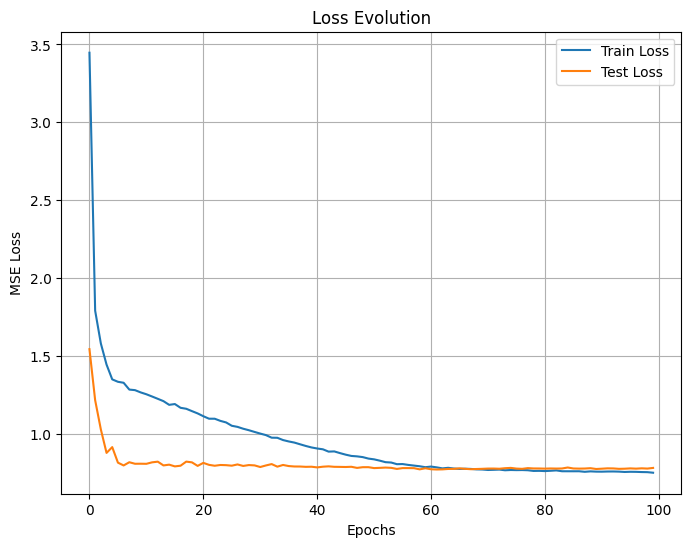

In [8]:
# Create the model
model = GCMC(
    num_users=num_users,
    num_movies=num_movies,
    num_relations=len(rating_types),
    hidden_dim=64,
    num_layers=2,
    dropout_rate=0.5
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Function to create model inputs
def create_model_inputs(users, movies, adj_matrices):
    return [
        tf.constant(users, dtype=tf.int32),
        tf.constant(movies, dtype=tf.int32),
        adj_matrices
    ]

# Training
print("TRAINING GCMC MODEL")


# Create inputs
train_inputs = create_model_inputs(train_users, train_movies, adj_matrices)
test_inputs = create_model_inputs(test_users, test_movies, adj_matrices)

# Training in batches (simulation)
epochs = 100
batch_size = 1024
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training
    epoch_loss = 0
    num_batches = 0
    
    for i in range(0, len(train_users), batch_size):
        end_idx = min(i + batch_size, len(train_users))
        batch_users = train_users[i:end_idx]
        batch_movies = train_movies[i:end_idx]
        batch_ratings = train_ratings[i:end_idx]
        
        batch_inputs = create_model_inputs(batch_users, batch_movies, adj_matrices)
        
        with tf.GradientTape() as tape:
            predictions = model(batch_inputs, training=True)
            loss = tf.reduce_mean(tf.square(predictions - batch_ratings))
        
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        epoch_loss += loss.numpy()
        num_batches += 1
    
    epoch_loss /= num_batches
    train_losses.append(epoch_loss)
    
    # Evaluation on test set
    test_predictions = model(test_inputs, training=False)
    test_loss = tf.reduce_mean(tf.square(test_predictions - test_ratings)).numpy()
    test_losses.append(test_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Test Loss = {test_loss:.4f}")


# FINAL EVALUATION AND VISUALIZATION

# Final predictions
final_predictions = model(test_inputs, training=False).numpy()

# Metrics
rmse = np.sqrt(mean_squared_error(test_ratings, final_predictions))
mae = mean_absolute_error(test_ratings, final_predictions)


print("FINAL RESULTS")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualization
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()